In [35]:
# import cv2
import random

def convert_yolo_to_pixels(bb, img_width, img_height):
    """Convert YOLO format bounding box to pixel coordinates."""
    x_center, y_center, width, height = bb
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)
    return x1, y1, x2, y2

def adjust_bbox_for_crop(original_bbox, crop_top_left, crop_width, crop_height, img_width, img_height):
    """Adjust the bounding box coordinates for the cropped image and convert to YOLO format."""
    x1, y1, x2, y2 = convert_yolo_to_pixels(original_bbox, img_width, img_height)
    crop_left, crop_top = crop_top_left

    # Adjust coordinates relative to the cropped area
    x1_cropped = x1 - crop_left
    y1_cropped = y1 - crop_top
    x2_cropped = x2 - crop_left
    y2_cropped = y2 - crop_top

    # Normalize coordinates to the cropped image dimensions
    x_center_cropped = (x1_cropped + x2_cropped) / 2 / crop_width
    y_center_cropped = (y1_cropped + y2_cropped) / 2 / crop_height
    width_cropped = (x2_cropped - x1_cropped) / crop_width
    height_cropped = (y2_cropped - y1_cropped) / crop_height

    return [x_center_cropped, y_center_cropped, width_cropped, height_cropped]

def random_crop(image, bbox, screen_width, screen_height):
    """Crop the image randomly such that the bounding box is within the cropped area."""
    # img_height, img_width = image.size
    img_width, img_height = image.size
    x1, y1, x2, y2 = convert_yolo_to_pixels(bbox, img_width, img_height)

    # Ensure the bounding box is smaller than the screen size
    if (x2 - x1) > screen_width or (y2 - y1) > screen_height:
        raise ValueError("Bounding box is larger than the screen dimensions.")

    # Randomly choose the top left corner of the cropped area
    left = random.randint(max(0, x2 - screen_width), min(x1, img_width - screen_width))
    print(f"y2 {y2}")
    print(f"y1 {y1}")
    print(f"screen_height {screen_height}")
    print(f"img_height {img_height}")
    print(f"max(0, y2 - screen_height) {max(0, y2 - screen_height)}")
    print(f"min(y1, img_height - screen_height) {min(y1, img_height - screen_height)}")
    top = random.randint(max(0, y2 - screen_height), min(y1, img_height - screen_height))

    right = left + screen_width
    bottom = top + screen_height
    # new_bbox = adjust_bbox_for_crop(bbox, (left, top), screen_width, screen_height, img_width, img_height)

    # return image[top:top+screen_height, left:left+screen_width], new_bbox
    cropped_image = image.crop((left, top, right, bottom))
    new_bbox = adjust_bbox_for_crop(bbox, (left, top), screen_width, screen_height, img_width, img_height)

    return cropped_image, new_bbox

# Usage Example
image_path = "/media/nvme_data/ehr_workflows/hf_home/hub/webui-7k-yolo-inner-box/test/images/1655937076413_default_1920-1080.jpg" # Replace with your image path
bb = [ 0.5344070278184481, 0.98828125, 0.032210834553440704, 0.016927083333333332]#[0.2125, 0.8953410981697172, 0.1734375, 0.007653910149750416]
# image = load_image(image_path)
image = Image.open(image_path)

# img_height, img_width = image.size
img_width, img_height = image.size

max_pixels = 1124 * 1124
# img_height, img_width, _ = image.shape    
print(f"Curr: Width {img_width} Height {img_height}")
if img_height * img_width > max_pixels:
    screen_ratio = 2234 / 3456 # height:weight
    new_img_width = img_width
    new_img_height = int(img_width * screen_ratio)
    print(f"New: Width {new_img_width} Height {new_img_height}")
    # screen_width, screen_height = 3456, 2234
    cropped_image, new_bbox = random_crop(image, bb, new_img_width, new_img_height)
else:
    cropped_image = image
    new_bbox = bb

Curr: Width 1920 Height 3160
New: Width 1920 Height 1241
y2 3149
y1 3096
screen_height 1241
img_height 3160
max(0, y2 - screen_height) 1908
min(y1, img_height - screen_height) 1919


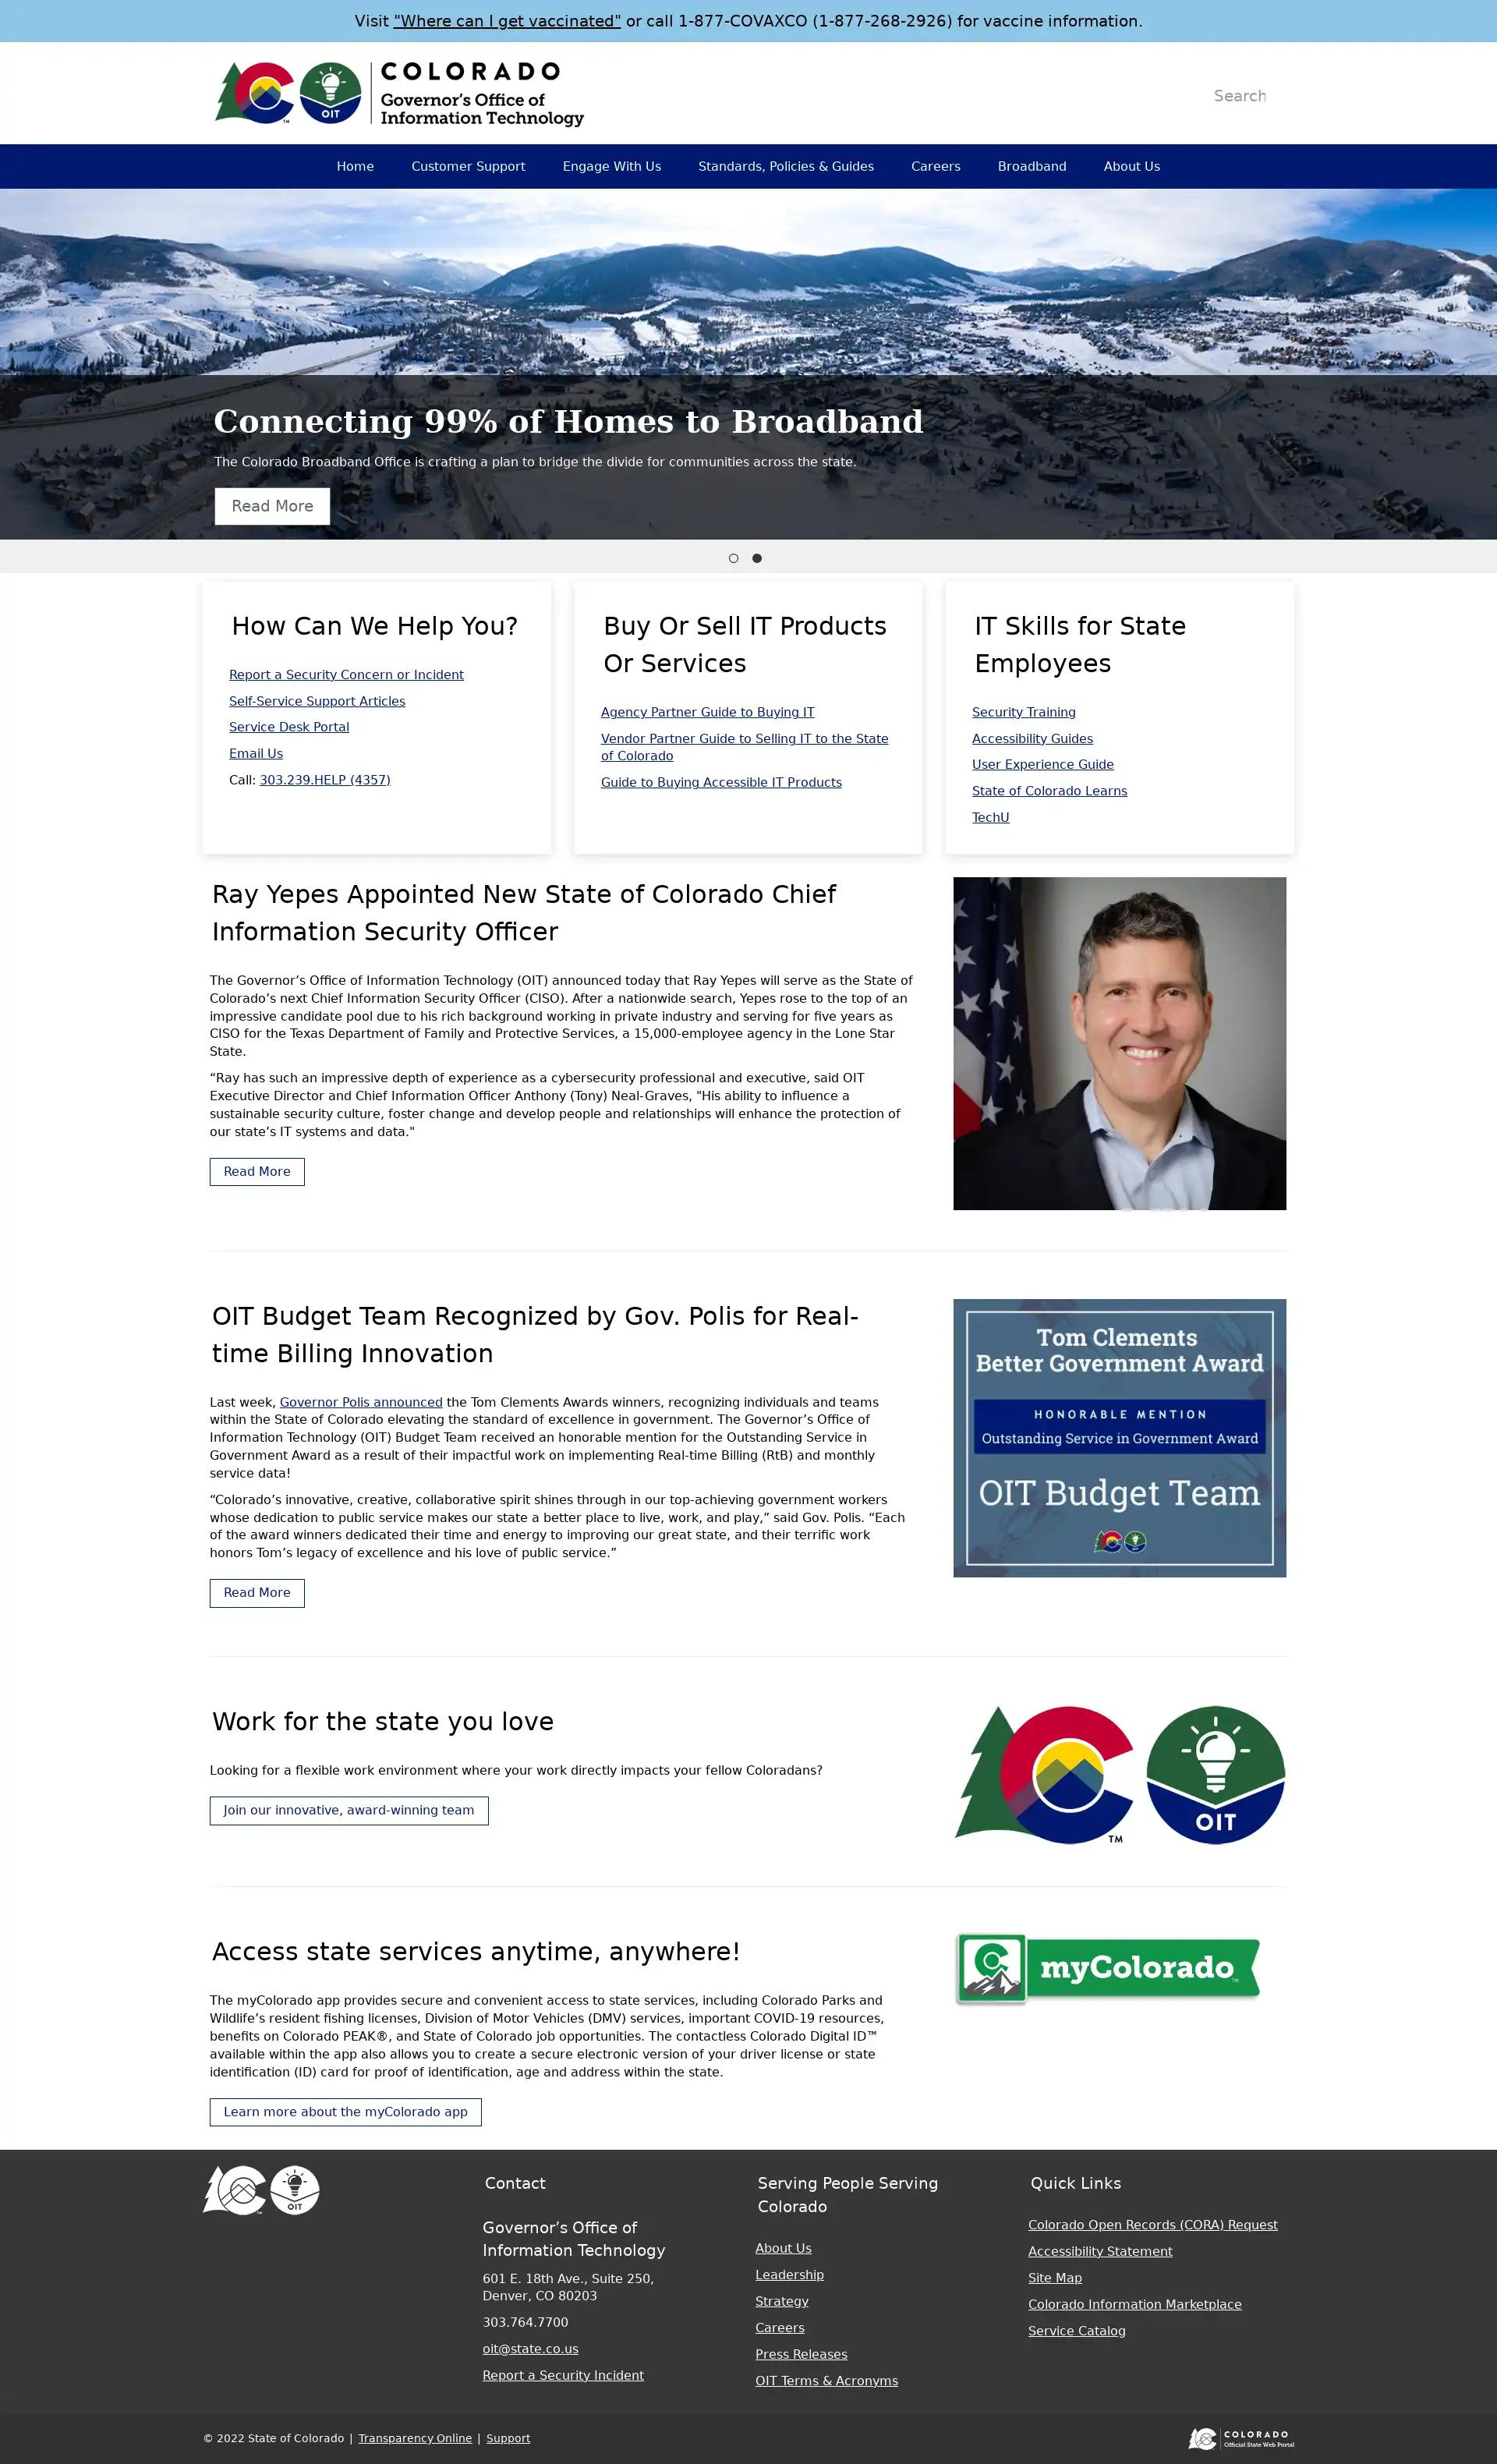

In [36]:
display(image)

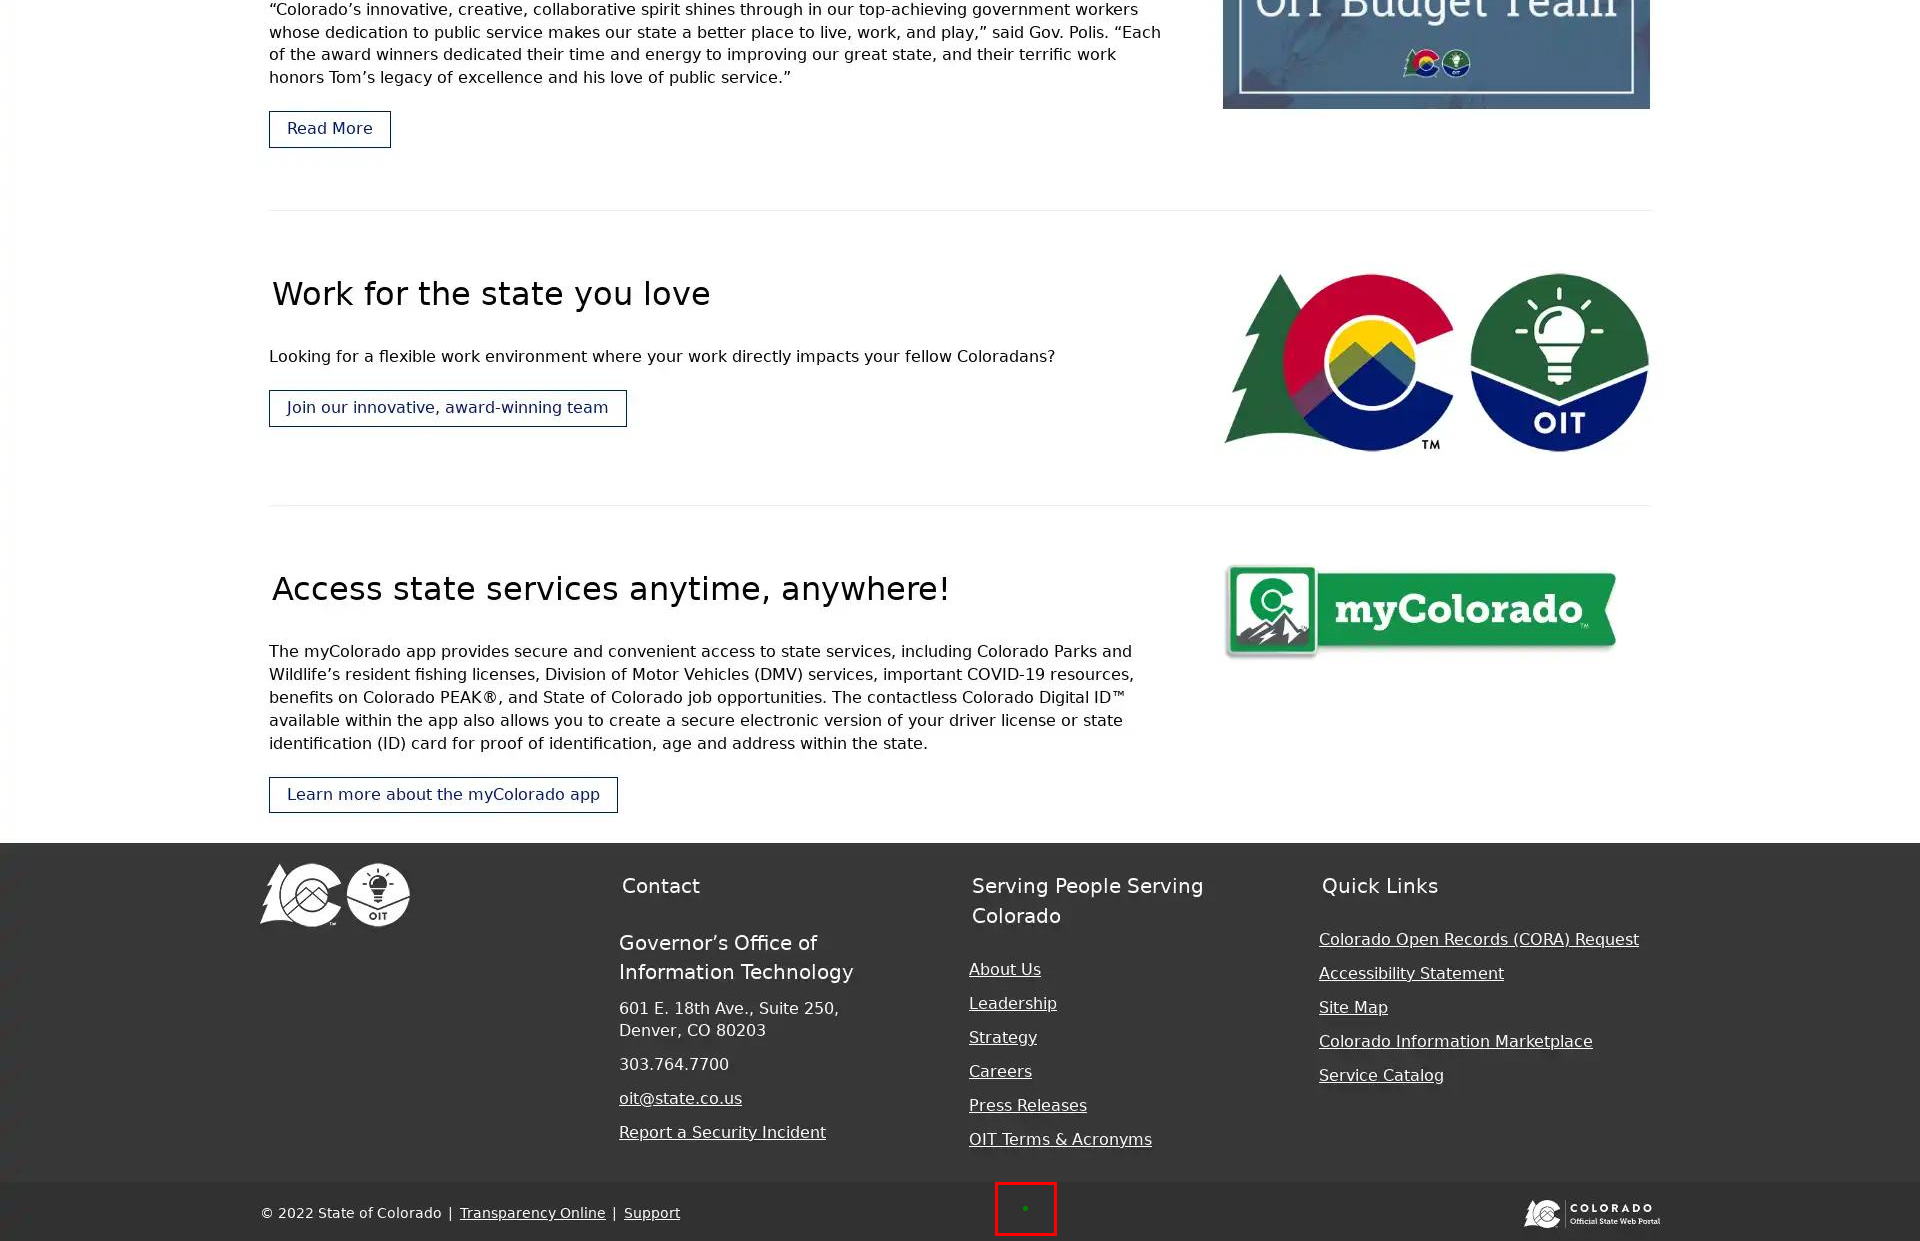

In [37]:
# Save or display cropped_image as needed
from IPython.display import display
# import IPython.display as display
from PIL import ImageDraw

# cropped_image = Image.fromarray(cropped_image)

# Initialize the drawing context with your image as background
draw = ImageDraw.Draw(cropped_image)

# Image dimensions
img_width, img_height = cropped_image.size

# Scale coordinates and dimensions to fit the image size
x_center_scaled = new_bbox[0] * img_width
y_center_scaled = new_bbox[1] * img_height
width_scaled = new_bbox[2] * img_width
height_scaled = new_bbox[3] * img_height

# Calculate top-left and bottom-right coordinates
top_left = (x_center_scaled - width_scaled / 2, y_center_scaled - height_scaled / 2)
bottom_right = (x_center_scaled + width_scaled / 2, y_center_scaled + height_scaled / 2)

draw.rectangle([top_left, bottom_right], outline="red",width=3)

# Draw a green dot at the center
center = (x_center_scaled, y_center_scaled)
draw.ellipse([center[0]-2, center[1]-2, center[0]+2, center[1]+2], fill="green")

display(cropped_image)